## Gaussian Process regression on the human tissue atlas. Ideal if can be done for all feature combinations.
* rna + original 204 features
* rna + protein embeddings
* rna + protein embeddings + protein length

Ratios are computed as log10(10^protein/10^mrna)

In [1]:
import scipy.stats
import sys
import os
sys.path.append('../../Utils')
from metrics import compute_metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
import gpflow
import time 

from gpflow.utilities import print_summary
from sklearn.model_selection import train_test_split
import sklearn.metrics
gpflow.config.set_default_float('float32')

In [2]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

ratios_path = data_dir+'29Atlas/QuantificationTables/Table_EV3/Table_EV3.tsv'
features_path = data_dir+'29Atlas/QuantificationTables/Table_EV6/Table_EV6.tsv'
embeddings_path =data_dir+'29Atlas/protein_embeddings/atlas_embeddings.pkl'

In [3]:
ratios = pd.read_csv(ratios_path,sep='\t',index_col=0)
features = pd.read_csv(features_path,sep='\t',index_col=0,usecols=[0]+list(range(4,208)))
with open(embeddings_path, 'rb') as file:
    embeddings = pickle.load(file)

In [4]:
#creating dataframe using avg embedding value only
avg_embeddings = pd.DataFrame(embeddings.avg_embedding.values.tolist(),
                                        index = embeddings.index)

#Including log2 protein length
protein_length = pd.DataFrame(np.log2(embeddings.loc[:,'protein_sequence'].str.len()))
protein_length.rename(columns = {'protein_sequence':'protein_length'}, inplace = True) 

#concating features together
combined_features = pd.concat([features,protein_length,avg_embeddings],axis='columns',sort=True)

#### Simple class object used to filter atlas dataset based on tissue

In [5]:
class atlas29():
    def __init__(self,ratios,features):
        """
        Data class to filter ratios and features tables for specific tissues and genes found in that tissue
        """
        assert isinstance(ratios,pd.DataFrame)
        assert isinstance(features,pd.DataFrame)
        
        self.ratios = ratios
        self.features = features
        self.tissues = [name.split('_')[0] for name in ratios.columns if '_PTR' in name]
        
    def filter_tissue(self,tissue_name):
        """
        Function to filter ratios and features for present genes and combine to single dataframe
        """
        assert tissue_name in self.tissues, "Given tissue name is not in data"
        
        genes_present = ~self.ratios[tissue_name+'_PTR'].str.contains('NA')
        ratios_present = self.ratios[[tissue_name+'_PTR']][genes_present].astype(float)
        features = ratios_present.join(self.features)
        return features
    
    def filter_tissue_mrna_p(self,tissue_name):
        """
        Function to filter ratios, mrna, protein and features for present genes and combine to single dataframe
        """
        assert tissue_name in self.tissues, "Given tissue name is not in data"
        
        genes_present = ~self.ratios[tissue_name+'_PTR'].str.contains('NA')
        ratios_present = self.ratios[[tissue_name+'_PTR',tissue_name+'_protein',tissue_name+'_mRNA']][genes_present].astype(float)
        features = ratios_present.join(self.features)
        return features

In [6]:
device = 1
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### GP using mrna and protein embeddings only

In [7]:
#First columns is ptr
atlas_mrna_embeddings = atlas29(ratios,combined_features.iloc[:,-64::])
atlas_mrna_embeddings_length = atlas29(ratios,combined_features.iloc[:,-65::])
atlas_mrna_original_204 = atlas29(ratios,combined_features.iloc[:,0:204])

In [8]:
def zscore(train_df):
    assert isinstance(train_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    zscored = (train_df-means)/stds
    return zscored, means, stds

In [9]:
tissue = 'Kidney'
zscore_values = {}

data = atlas_mrna_embeddings.filter_tissue_mrna_p(tissue).drop(f'{tissue}_PTR',axis=1)
SEED = 10
train,test = train_test_split(data,test_size=0.1)#,random_state=SEED)
SEED = 42
test,val = train_test_split(test,test_size=0.5)#,random_state=SEED)

#Zscore data
train, train_mean, train_std = zscore(train) #zscore data
zscore_values[tissue] = [train_mean,train_std]
val = (val-train_mean)/train_std #zscore validation data using mean and std from train set
test = (test-train_mean)/train_std #zscore test data using mean and std from train set



protein_column = f'{tissue}_protein'
x_train = train.loc[:, train.columns != protein_column].values.astype(np.float32)
y_train = train[[protein_column]].values.astype(np.float32)

x_val = val.loc[:, val.columns != protein_column].values.astype(np.float32)
y_val = val[[protein_column]].values.astype(np.float32)

x_test = test.loc[:, test.columns != protein_column].values.astype(np.float32)
y_test = test[[protein_column]].values.astype(np.float32)

#Initialize kernel, indicate lengthscale to initialize ARD
k = gpflow.kernels.SquaredExponential(lengthscale=[1]*x_train.shape[1])
#k = gpflow.kernels.Matern52(lengthscale=[1]*x_train.shape[1])

print_summary(k)

m = gpflow.models.GPR(data=(x_train, y_train), kernel=k, mean_function=None)
m.likelihood.variance.assign(0.01)
print_summary(m)

name                            class      transform    prior    trainable    shape    dtype    value
------------------------------  ---------  -----------  -------  -----------  -------  -------  --------------
SquaredExponential.variance     Parameter  Softplus              True         ()       float32  1.0
SquaredExponential.lengthscale  Parameter  Softplus              True         (65,)    float32  [1., 1., 1....
name                     class      transform                prior    trainable    shape    dtype    value
-----------------------  ---------  -----------------------  -------  -----------  -------  -------  --------------
GPR.kernel.variance      Parameter  Softplus                          True         ()       float32  1.0
GPR.kernel.lengthscale   Parameter  Softplus                          True         (65,)    float32  [1., 1., 1....
GPR.likelihood.variance  Parameter  Softplus + AffineScalar           True         ()       float32  0.009999949


In [10]:
neg_likelihood = list()
neg_likelihood.append(-m.log_marginal_likelihood())

lengthscales = m.kernel.lengthscale.numpy().copy()
#np.vstack((model.kernel.base_kernel.lengthscale.numpy(),model.kernel.base_kernel.lengthscale.numpy()))

kernel_variance = list()
kernel_variance.append(m.kernel.variance.numpy())

model_variance = list()
model_variance.append(m.likelihood.variance.numpy())

train_mse = list()
train_pearson = list()
validation_mse = list()
validation_pearson = list()

optimizer = tf.keras.optimizers.Adam()
regularizer = tf.keras.regularizers.l2(l=100)


In [12]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    global lengthscales, x_val, y_val, x_train, y_train
    neg_likelihood.append(-m.log_marginal_likelihood())
    lengthscales = np.vstack((lengthscales,m.kernel.lengthscale.numpy().copy()))
    kernel_variance.append(m.kernel.variance.numpy())
    model_variance.append(m.likelihood.variance.numpy())
    
    mean, var = m.predict_f(x_val)
    validation_mse.append(sklearn.metrics.mean_squared_error(mean.numpy(),y_val))
    validation_pearson.append(scipy.stats.pearsonr(mean.numpy().squeeze(),y_val.squeeze())[0])
    
    mean, var = m.predict_f(x_train)
    train_mse.append(sklearn.metrics.mean_squared_error(mean.numpy(),y_train))
    train_pearson.append(scipy.stats.pearsonr(mean.numpy().squeeze(),y_train.squeeze())[0])
    return - m.log_marginal_likelihood()

#Initial test ~75 seconds with maxiter 100, signifiantly longer with maxiter 1000 ~875 seconds
time_start = time.time()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=75))
print(f'Run time {time.time()-time_start}')

print_summary(m)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [13]:
## predict mean and variance of latent GP at train points
mean, var = m.predict_f(x_val)
metrics = compute_metrics(mean.numpy(), y_val, y_train, fc_scale=2)
metrics

{'mae': 0.55092317,
 'mse': 0.47358343,
 'smse': 0.47241709166692175,
 'r2': 0.5264362555092617,
 'evs': 0.5264368057250977,
 'spearmanrho': 0.7016413455393904,
 'spearmanrho_p': 1.4248775120879875e-174,
 'pearsonr': 0.7255600361592465,
 'pearsonr_p': 2.754525980443205e-192,
 'median_abs_fc': 1.3883186371714393,
 'mean_abs_fc': 1.4650228521158795}

In [14]:
## predict mean and variance of latent GP at train points
mean, var = m.predict_f(x_test)
metrics = compute_metrics(mean.numpy(), y_test, y_train, fc_scale=2)
metrics

{'mae': 0.5524966,
 'mse': 0.49293554,
 'smse': 0.4862497855191804,
 'r2': 0.5131235043549106,
 'evs': 0.5131473541259766,
 'spearmanrho': 0.6888916134042333,
 'spearmanrho_p': 7.756431346988877e-166,
 'pearsonr': 0.7163434419253718,
 'pearsonr_p': 3.041266269616015e-185,
 'median_abs_fc': 1.369922030469543,
 'mean_abs_fc': 1.4666215184783338}

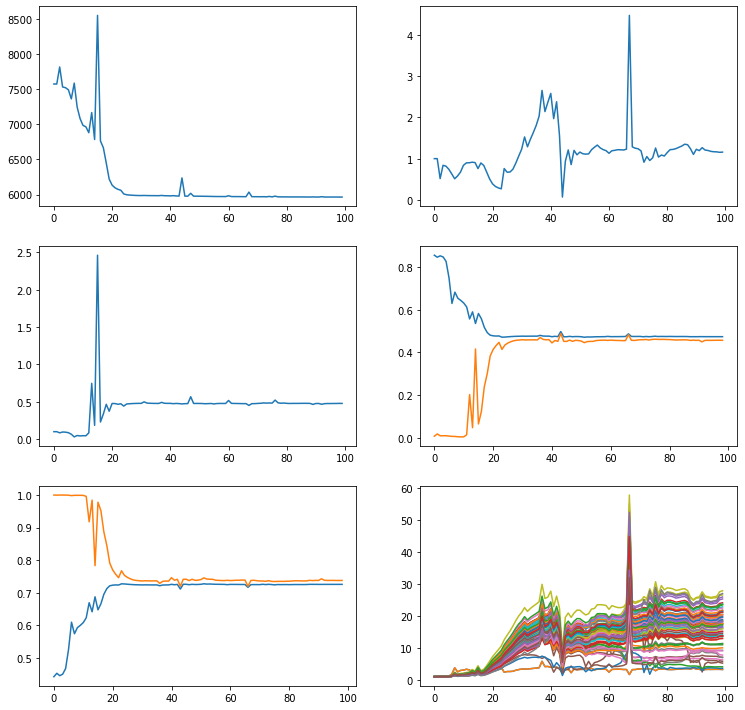

In [15]:
fig = plt.figure()
fig.set_size_inches(12.5,12.5)
ax = fig.add_subplot(321)
ax.plot(range(0,len(neg_likelihood)),neg_likelihood)

ax = fig.add_subplot(322)
ax.plot(range(0,len(kernel_variance)),kernel_variance)

ax = fig.add_subplot(323)
ax.plot(range(0,len(model_variance)),model_variance)

ax = fig.add_subplot(324)
ax.plot(range(0,len(validation_mse)),validation_mse)
ax.plot(range(0,len(validation_mse)),train_mse)

ax = fig.add_subplot(325)
ax.plot(range(0,len(validation_pearson)),validation_pearson)
ax.plot(range(0,len(validation_pearson)),train_pearson)
ax = fig.add_subplot(326)
ax.plot(range(0,len(lengthscales[:,0])),lengthscales[:,0])
for i in range(lengthscales.shape[1]):
    ax.plot(range(0,len(lengthscales[:,i])),lengthscales[:,i])

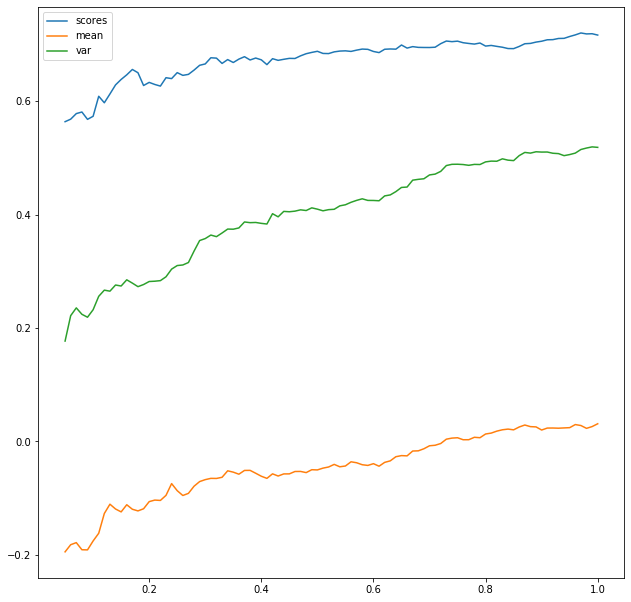

In [16]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]
sorted_var = var.numpy()[sorted_indicies]

scores=[]
percent_var=[]
percent_mean=[]

intervals = np.arange(.05,1.01,0.01)
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[0:index]
    percent_mean.append(top_means.mean())
    percent_var.append(top_means.var())
    top_means_ytruth = sorted_ytruth[0:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['pearsonr'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores,label='scores')
ax.plot(intervals,percent_mean,label='mean')
ax.plot(intervals,percent_var,label='var')
ax.legend()